# Notebook 1: Zeitbeiwertverfahren, Einheitsganglinie, Block- und detaillierte Modelle

Einführung der Einheitsganglinie, des Zeitbeiwertverfahren und der blockbasierten sowie flächendetaillierten hydrologischen Modellierung.

## Einführung

In diesem Notebook werden verschiedene Möglichkeiten zur Schätzung einer Niederschlags-Abfluss-Ganglinie mit unterschiedlichem Komplexitätsgrad angewandt.

![Beispiel Hydrograph mit Komponentenflussbeiträgen](img/hydrograph_example.png)
(Quelle: [Margulis 2020](https://margulis-group.github.io/textbook/))

Zunächst wird das Zeitbeiwertverfahren angewandt, um anhand von empirischen Werten den Spitzenfluss für ein kleines Einzugsgebiet (EZG) im Kanadischen Whistler zu schätzen. Anschließend stellen wir einige komplexere Modelle vor. Hierzu gehören die Modelle des Soil Conservation Service (SCS), Unit Hydrograph (SCS-UH) und Curve Number (SCS-CN), welche ihr auch in der Vorlesung kennengelernt habt. Wir berechnen die maximale Abflusspende mithilfe der CN-Methode, wobei davon ausgegangen wird, dass die EZG-Eigenschaften wie Neigung und Rauheit im gesamten EZG homogen sind. In diesem Fall werden also alle Bereiche des Einzugsgebiets als eine Einheit behandelt, was auch als Block-Modell bezeichnet wird.

Abschließend verwenden wir eine Open-Source-Geodatenbibliothek, um aus digitalen Höhendaten (DEM) ein einfaches detailliertes Modell des EZGs zu erstellen. Wir berechnen die Fließrichtung und die Fließakkumulation, um ein EZG abzugrenzen und das Gewässernetz zu definieren, und erstellen daraus eine Ganglinie für ein Niederschlagsereignis.

Hierzu dient uns ein realitätsnahes Projekt, bei dem die resultierenden Abflüsse ermittelt werden sollen. Der sich ergebende Wasserstand betrifft ein hypothetisches Gerinne am Auslass dieses Einzugsgebietes. Hierdurch soll ein Gefühl für die Bandbreite des Spitzenabflusses als Reaktion auf ein Niederschlagsereignis entwickelt werden.

In [1]:
# importiere die nötigen Pakete
import os
import pandas as pd
import numpy as np
import math

# Statistik Bilbiothek
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.colors as colors

from pysheds.grid import Grid

In [2]:
# zeige aktuellen Arbeitsordner an
working_directory = os.getcwd()
print(working_directory)

C:\Users\grego\OneDrive - Universitaet Duisburg-Essen\GitHub\repos\Wassermengenwirtschaft_und_Klimawandel\Inhalt\Notebooks\Hausarbeit


## Niederschlagsdaten herunterladen und importieren

Wir können die Anwendung des [Pacific Climate Impacts Consortium](https://services.pacificclimate.org/met-data-portal-pcds/app/) (PCIS) nutzen, um Wetterdaten in der Gegend von Whistler abzurufen. Für diese Hausarbeit verwenden wir historische Wetterdaten der Station des Meteorological Service of Canada (MSC) in Whistler, BC.

Unter Verwendung des bereitgestellten Filters *Obervation Frequency* gibt es einige Klimastationen mit stündlichen Niederschlagsdaten:

![Standort der Klimastationen von Environment Canada in Whistler mit stündlichen Daten.](img/pcds_hourly_stn.png)

Wir betrachten die Station (*ID 1048899: Whistler (2014-2022)*) als Beispiel, schauen uns aber auch eine andere an, da die PCIS-Webanwendung nahelegt, dass diese Station stündliche Daten hat, dies aber nicht der Fall ist. Das ist ebenfalls für alle anderen Stationen *außer einem* (925 – grünes Dreieck, rot umkreist) der Fall. **Wichtig: Ihr seid immer für eure eigene Datenvalidierung verantwortlich.**

In der PCIS-Datenbank sind nur an einem Standort stündliche Daten der Region Whistler verfügbar und das nur für einen kurzen Zeitraum im Jahr 2005. Diese Daten sind von der von der Wildfire Management Branch (FLNRO-WMB) des Ministeriums für Wälder, Land und Ressourcen (ID 925 ZZ REMSATWX1).

Überprüft eigenständig, was hier gezeigt wird indem ihr auf die Seite des PCIS geht. Die Website ist oben verlinkt. Die entsprechende Lage von Whistler könnt ihr bspw. Google Maps entnehmen.

In [3]:
# importiere Niederschlagsdaten
daily_df = pd.read_csv('../../Notebook_Daten/Hausarbeit_Daten/Whistler_348_climate.csv', parse_dates=True, index_col=['Date/Time'])
daily_df.dropna(subset=['Total Precip (mm)'], inplace=True)
daily_df.head()

Station Name  Year  Month  Day Data Quality  Max Temp (°C)  \
Date/Time                                                               
1976-11-22     WHISTLER  1976     11   22          NaN            5.6   
1976-11-23     WHISTLER  1976     11   23          NaN            5.0   
1976-11-24     WHISTLER  1976     11   24          NaN            5.0   
1976-11-25     WHISTLER  1976     11   25          NaN            4.4   
1976-11-26     WHISTLER  1976     11   26          NaN            2.2   

           Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ...  \
Date/Time                                                              ...   
1976-11-22           NaN            NaN             M             NaN  ...   
1976-11-23           NaN            0.6           NaN             2.8  ...   
1976-11-24           NaN            2.2           NaN             3.6  ...   
1976-11-25           NaN            0.6           NaN             2.5  ...   
1976-11-26           NaN           -6.7           NaN            -2.3  ...   

           Total Snow (cm)  Total Snow Flag Total Precip (mm)  \
Date/Time                                                       
1976-11-22             0.0              NaN               1.5   
1976-11-23             0.0              NaN              12.7   
1976-11-24             0.0              NaN               2.5   
1976-11-25             0.0              NaN               0.0   
1976-11-26             0.0              NaN               0.0   

            Total Precip Flag Snow on Grnd (cm)  Snow on Grnd Flag  \
Date/Time                                                            
1976-11-22                NaN               NaN                NaN   
1976-11-23                NaN               NaN                NaN   
1976-11-24                NaN               NaN                NaN   
1976-11-25                NaN               NaN                NaN   
1976-11-26                NaN               NaN                NaN   

           Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
Date/Time                                                    
1976-11-22                       NaN                   NaN   
1976-11-23                       NaN                   NaN   
1976-11-24                       NaN                   NaN   
1976-11-25                       NaN                   NaN   
1976-11-26                       NaN                   NaN   

           Spd of Max Gust (km/h)  Spd of Max Gust Flag  
Date/Time                                                
1976-11-22                    NaN                   NaN  
1976-11-23                    NaN                   NaN  
1976-11-24                    NaN                   NaN  
1976-11-25                    NaN                   NaN  
1976-11-26                    NaN                   NaN  

[5 rows x 27 columns]

In [4]:
import os

In [5]:
os.getcwd()

'C:\\Users\\grego\\OneDrive - Universitaet Duisburg-Essen\\GitHub\\repos\\Wassermengenwirtschaft_und_Klimawandel\\Inhalt\\Notebooks\\Hausarbeit'

In [6]:
# Merke dass die ascii Datei die Zeichenfolge 'None' für NaN
# wir berücksichtigen das während des Datenimports
hourly_df = pd.read_csv('../../Notebook_Daten/Hausarbeit_Daten/925.ascii',
header=1, na_values=[' None'], parse_dates=[' time'])

# Merke das das ascii Format die Spaltenüberschriften mit spaces importiert
# die wir bereinigen müssen
hourly_df.columns = [e.strip() for e in hourly_df.columns]
hourly_df.set_index('time', inplace=True, drop=True)
hourly_df.head()

wind_speed  temperature  wind_direction  \
time                                                           
2005-09-28 10:00:00        12.9         11.6           234.0   
2005-09-28 11:00:00        14.8         11.2           229.0   
2005-09-28 12:00:00        10.4         11.1           224.0   
2005-09-28 13:00:00        13.8         10.5           247.0   
2005-09-28 14:00:00        13.9         10.0           245.0   

                     relative_humidity  precipitation  
time                                                   
2005-09-28 10:00:00               61.0            0.0  
2005-09-28 11:00:00               68.0            0.0  
2005-09-28 12:00:00               76.0            0.2  
2005-09-28 13:00:00               79.0            0.0  
2005-09-28 14:00:00               80.0            0.2

## Daten plotten

Hier verwenden wir die Datenvisualisierungsbibliothek Bokeh, um die Niederschlagsdaten zum ersten Mal grafisch darzustellen. Die Bibliothek bietet die Flexibilität, Zeitskalen zu vergrößern und zu verkleinern, was bei der Erkundung und Überprüfung der Daten sehr hilfreich ist. Dies sollte immer einer der ersten Schritte bei der Modellerstellung sein.

In [7]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar, ColumnDataSource
output_notebook()

hourly_source = ColumnDataSource(hourly_df)
daily_source = ColumnDataSource(daily_df)

p = figure(title=f'Niederschlagsdaten', width=750, height=300, x_axis_type='datetime')

p.vbar(x='Date/Time', width=pd.Timedelta(days=1), top='Total Precip (mm)', 
bottom=0, source=daily_source, legend_label='Tägl. Niederschlag', 
color='royalblue')

p.vbar(x='time', width=pd.Timedelta(hours=1), top='precipitation', 
bottom=0, source=hourly_source, legend_label='Stündlicher Niederschlag', 
color='gold')

p.legend.location = 'top_left'
p.xaxis.axis_label = 'Datum'
p.yaxis.axis_label = 'Niederschlag [mm]'
p.toolbar_location='above'
show(p)

Loading BokehJS ...

Verwendet das Zoom-Tool, um die gemessenen Werte vom 28. bis 29. September 2005 zu vergleichen. Passen die täglichen Volumina hierzu?

In [8]:
hourly_df['day'] = hourly_df.index.day
hourly_tot = hourly_df.groupby('day')['precipitation'].sum()
print(hourly_tot)
daily_check = daily_df['2005-09-28':'2005-09-29']['Total Precip (mm)'].copy()
print(daily_check)

day
28    17.4
29    22.8
Name: precipitation, dtype: float64
Date/Time
2005-09-28    26.2
2005-09-29    17.1
Name: Total Precip (mm), dtype: float64


In [9]:
hourly_df

wind_speed  temperature  wind_direction  \
time                                                           
2005-09-28 10:00:00        12.9         11.6           234.0   
2005-09-28 11:00:00        14.8         11.2           229.0   
2005-09-28 12:00:00        10.4         11.1           224.0   
2005-09-28 13:00:00        13.8         10.5           247.0   
2005-09-28 14:00:00        13.9         10.0           245.0   
2005-09-28 15:00:00        12.1          8.9           231.0   
2005-09-28 16:00:00         8.9          8.5           227.0   
2005-09-28 17:00:00        11.3          8.2           226.0   
2005-09-28 18:00:00        12.3          7.9           225.0   
2005-09-28 19:00:00         7.4          7.8           180.0   
2005-09-28 20:00:00         6.2          7.7           183.0   
2005-09-28 21:00:00         7.6          7.9           178.0   
2005-09-28 22:00:00         7.1          8.0           200.0   
2005-09-28 23:00:00         9.2          8.1           195.0   
2005-09-29 00:00:00         7.7          8.2           211.0   
2005-09-29 01:00:00         8.4          8.4           214.0   
2005-09-29 02:00:00         7.7          8.6           218.0   
2005-09-29 03:00:00         6.5          8.6           186.0   
2005-09-29 04:00:00         8.3          8.5           199.0   
2005-09-29 05:00:00         8.6          8.6           188.0   
2005-09-29 06:00:00         7.6          8.6           202.0   
2005-09-29 07:00:00         8.0          8.6           157.0   
2005-09-29 08:00:00         6.2          9.0           157.0   
2005-09-29 09:00:00        11.3          9.2           185.0   
2005-09-29 10:00:00         3.6          9.2           174.0   
2005-09-29 11:00:00         9.3          9.6           203.0   
2005-09-29 12:00:00         9.8         10.1           216.0   
2005-09-29 13:00:00        12.9         10.6           224.0   

                     relative_humidity  precipitation  day  
time                                                        
2005-09-28 10:00:00               61.0            0.0   28  
2005-09-28 11:00:00               68.0            0.0   28  
2005-09-28 12:00:00               76.0            0.2   28  
2005-09-28 13:00:00               79.0            0.0   28  
2005-09-28 14:00:00               80.0            0.2   28  
2005-09-28 15:00:00               84.0            1.0   28  
2005-09-28 16:00:00               88.0            1.2   28  
2005-09-28 17:00:00               92.0            2.2   28  
2005-09-28 18:00:00               93.0            2.4   28  
2005-09-28 19:00:00               95.0            1.6   28  
2005-09-28 20:00:00               96.0            2.0   28  
2005-09-28 21:00:00               95.0            2.6   28  
2005-09-28 22:00:00               95.0            2.6   28  
2005-09-28 23:00:00               96.0            1.4   28  
2005-09-29 00:00:00               97.0            2.4   29  
2005-09-29 01:00:00               96.0            1.2   29  
2005-09-29 02:00:00               98.0            0.8   29  
2005-09-29 03:00:00               98.0            0.4   29  
2005-09-29 04:00:00               98.0            0.8   29  
2005-09-29 05:00:00               98.0            0.6   29  
2005-09-29 06:00:00               98.0            1.2   29  
2005-09-29 07:00:00               98.0            1.6   29  
2005-09-29 08:00:00               97.0            1.6   29  
2005-09-29 09:00:00               96.0            2.0   29  
2005-09-29 10:00:00               98.0            5.4   29  
2005-09-29 11:00:00               96.0            2.8   29  
2005-09-29 12:00:00               96.0            1.2   29  
2005-09-29 13:00:00               96.0            0.8   29

Die Niederschlagssumme für beide Tage liegt sehr nahe beieinander. Die Mengen der einzelnen Tage stimmen jedoch nicht überein, obwohl diese Stationen nahe beieinander liegen (die Whistler-Station ist das rote Dreieck direkt nördlich des grünen Dreiecks in der Karte oben).

Wenn wir uns zufällig für *diesen bestimmten* Tag interessieren, welche anderen Informationen könnten in Bezug auf den Energieeintrag relevant sein? Schaut euch die Datenspalten an:

In [10]:
daily_df.columns

Index(['Station Name', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)',
       'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)',
       'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag',
       'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)',
       'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag'],
      dtype='object')

Tagestemperatur und dem Schnee am Boden? Eventuell gibt es auch eine Kennzeichnungen zur Datenqualität?

In [11]:
climate_check = daily_df['2005-09-28':'2005-09-29'][['Snow on Grnd (cm)', 'Mean Temp (°C)']].copy()
climate_check

Snow on Grnd (cm)  Mean Temp (°C)
Date/Time                                    
2005-09-28                0.0             7.0
2005-09-29                0.0            10.1

In [12]:
flag_check = daily_df['2005-09-28':'2005-09-29'][['Snow on Grnd Flag', 'Mean Temp Flag', 'Total Precip Flag']].copy()
flag_check

Snow on Grnd Flag Mean Temp Flag Total Precip Flag
Date/Time                                                    
2005-09-28               NaN            NaN               NaN
2005-09-29               NaN            NaN               NaN

Aus den obigen Zellen ist ersichtlich, dass es keine besondere Kennzeichnung der Datenqualität gibt und auch kein Schnee auf dem Boden aufgezeichnet wurde. Daher haben wir vielleicht etwas mehr Vertrauen in die Tagesdaten, obwohl es schwierig ist, die Zeit zwischen den beiden Datensätzen in Einklang zu bringen. Es könnte ein Zeitzonenproblem sein, da einige Behörden die Zeiten in UTC melden und somit 7-8 Stunden voraus sind. Es könnte auch daran liegen, wie die Zeitstempel bei der Aggregation der Daten gehandhabt werden. In einem realen Projekt würde dies eine zusätzliche Überprüfung erfordern.

## Beschreibung des Projekts

Stellt euch vor, ihr arbeitet in einem kleinen Projektteam an der Planierung und Neupflasterung der Fläche rund um den Parkplatz 4. Ziel des Projektes ist auch die Installation einer Drainage, um das Wasser vom Parkplatz aufzufangen und in ein Regenrückhaltebecken (RRB) umzuleiten, anstatt es in den FitzSimmons Bach zu leiten. Im RRB erfolgt dann eine stoffliche Vorbehandlung, um bei der Einleitung in das Gewässer das dortige Ökosystem nicht zu schädigen.

![Satellitenbild der Tagesfläche Lot 4 in Whistler](img/lot4_diagram1.png)

Das Projekt beginnt im Sommer und soll im Herbst abgeschlossen sein. Nimm für diese Aufgabe an, dass es sich um ein Einzugsgebiet von ca. **1 $km^2$** handelt, das über ein neu zu planendes Gerinne in ein RRB mündet, bevor es in den FitzSimmons Bach geleitet wird.

>**Frage:** Für ein Einzugsgebiet, das nur $1 $km^2$ groß ist, welche Niederschlagsdauer ist für die Abschätzung des Scheitelabflusses erforderlich? *z.B. 1 Minute, 10 Minuten, 1 Stunde, 6 Stunden, 24 Stunden, 48 Stunden?

Es gibt auch eine Stelle, an der ein natürliches Gerinne vorhanden ist, das der Einfachheit halber für das Projekt genutzt werden könnte. Dadurch könnten Ausgrabungen vermieden und der enge Zeitplan des Projekts beschleunigt werden. Der Standort müsste vermessen werden, um die genauen Abmessungen zu ermitteln.

Angenommen, ihr gebt die Vermessung in Auftrag und erhaltet von der Vermesser:in die folgenden Ergebnisse der natürlichen Geometrie des bereits vorhandenen Getinnes.

* Kanalbreite (b): 2 $m$
* Tiefe des Gerinnes (h): 0,5 $m$
* Hydraulisches Gefälle (S): 0,005 (0,5 %)
* Rauheit (n): 0,017 (rauer Asphalt)

Im Wesentlichen geht es also darum, zu beurteilen, ob der vorhandene Kanal für die natürliche Entwässerung ausreicht. Und wie könnt ihr sicher sein, dass dies auch bei Starkregen der Fall ist? Ihr beginnt mit der Berechnung der Abflusskapazität:

### Berechnen der Abflusskapazität

Da die Gerinnegeometrie bekannt ist ist es möglich, die Abflusskapazität unseres Grinnes zu bestimmen. Wir berechnen zunächst die maximale Kapazität und bewerten dann, wie sich unser Spitzenabfluss hierzu verhält. Zur Abschätzung der Fließgeschwindigkeit eines Gewässers können wir die Fließformel nach Gauckler-Manning-Strickler  anwenden:

$$V_{avg} = \frac{R^{2/3}\cdot S^{1/2}}{N} $$

In [13]:
b, h = 2, 0.5 # height, width in metres
# Querschnittsfläche
A = b * h
perim = 2 * b + 2 * h
# hydraulischer Radius
R = A / perim
# Gefälle
S = 0.005
# Strickler Beiwert
n_manning = 0.017

# average velocity
V_avg_Gerinne =  R**(2.0/3) * S**(1.0/2) / n_manning
print(f'Die durchschnittliche Fließgeschwindigkeit bei vollem Durchfluss beträgt {V_avg_Gerinne:.1f}m/s')
Q_Gerinne_Kapazität = V_avg_Gerinne * A
print(f'Die volle Abflusskapazität des Gerinnes beträgt {Q_Gerinne_Kapazität:.1f} m^3/s')

Die durchschnittliche Fließgeschwindigkeit bei vollem Durchfluss beträgt 1.4m/s
Die volle Abflusskapazität des Gerinnes beträgt 1.4 m^3/s


## Berechnung der Ganglinie

Langzeitaufzeichnungen mit gleichzeitig hoher zeitlicher Auflösung sind nur in seltenen Fällen zu finden, weshalb **wir mit den verfügbaren Informationen unser Bestes geben**. Im Folgenden sehen wir uns einige Möglichkeiten zur Erstellung einer Ganglinie an, die einen variierenden Detaillierungsgrad haben.

Grundsätzlich werden Ganglinien erstellt oder zumindest der Scheitelabfluss bestimmt, um Wasserbauwerke und andere Ingenieurbauwerke planen zu können. Wir beginnen mit einer sehr einfachen Schätzung, die nur minimale Eingangsinformationen benötigt, und gehen dann zu komplexeren Methoden über, die mehr Eingangsdaten benötigen.

In der Hydrologie interessieren uns v.a. Unter- und Überschreitungswahrscheinlichkeiten. Mit anderen Worten: Wie groß ist die Wahrscheinlichkeit, dass der Durchfluss an einem bestimmten Ort bei einer bestimmten Jährlichkeit die Kapazität des Gerinnes (oder eines Bauwerkes) überschreitet? 

**Für diese Art von Problemen gibt es keine richtige Antwort, sie sind offen und subjektiv – was bedeutet, dass jede Antwort ein gewisses Maß an (technischem) Urteilsvermögen erfordert.** Das Thema Risiko wurde in der Vorlesung besprochen. Im Moment konzentrieren wir uns nur auf verschiedene Verfahren zur Übertragung einer effektiven Niederschlagsganglinie in eine Ganglinie des Direktabflusses.

### Konvertiert das Volumen (mm pro Stunde oder Tag) in die Einheit des Volumenstromes

Der Abfluss wird normalerweise in $\frac{m^3}{s}$ gemessen und der Niederschlag wird häufig in mm pro Stunde oder Tag angegeben. Konvertiert den $\frac{mm}{Tag}$-Niederschlag in $\frac{m^3}{s}$.

$$1 \frac{mm}{Tag} \times \frac{1 m}{1000 mm} \times \frac{1 Tag}{24 h} \times \frac{1 h}{ 3600 s} \times 1 km^2 \times \frac{1000 m \times 1000 m}{1 km^2}= \frac{1}{86.4} \frac{m^3}{s}$$

## Zeitbeiwertverfahren

Das Zeitbeiwertverfahren ist das am häufigsten verwendete Fließzeitverfahren zur Ermittlung des Scheitelabflusses von einer gleichmäßig überregneten Fläche mit einer konstanten Regenspende und einem konstanten Abflussbeiwert.  Im englischsprachigen Raum wird das Verfahren als "rational formula" oder "rational method"  (Verhältnismethode) bezeichnet. 

Die Bezeichnung "Zeitbeiwertverfahren" stammt aus früheren Zeiten, als die Regenspende **I** aus dem Produkt einer Bezugsregenspende und eines Zeitbeiwertes **C** für eine bestimmte Regendauer und Regenhäufigkeit berechnet wurde.

Info zu dem Vorgehen in Deutschland:
Inzwischen werden meistens die regionalisierten Starkniederschlagsauswertungen des Deutschen Wetterdienstes (Kostra-Atlas) oder andere Niederschlagsauswertungen aus örtlich gewonnenen Daten verwendet.

Beim Fließzeitverfahren (mehr Infos [hier](https://www.tad.usace.army.mil/Portals/53/docs/TAA/AEDDesignRequirements/AED%20Design%20Requirements-%20Hydrology%20Studies_Feb-11.pdf)) wird davon ausgegangen, dass die maßgebende Regendauer der Fließzeit im betrachteten Einzugsgebiet entspricht. Diese Zeit wird auch als Konzentrationszeit bezeichnet und kann auf diese Weise berechnet werden:

$$Q = k\cdot C\cdot I \cdot a$$

mit:

* **Q**: Scheitelabfluss [$m^3/s$]
* **k**: 0.278 [-]   Notiz: $\quad 1\frac{mm}{hr} \cdot \frac{1\text{hr}}{3600s} \cdot \frac{1m}{1000mm} \cdot 1 \text{km}^2 \cdot \frac{1\times 10^6 m^2}{1\text{km}^2} = \frac{1}{3.6} = 0.278 \frac{m^3}{s}$
* **C**: Abflussbeiwert [-]
* **I**: Regenspende [mm/hr]
* **a**: Einzugsgebietsfläche [$km^2$]

Wir haben die Einzugsgebietsfläche bereits ermittelt und benötigen somit nur zwei weitere Informationen, um den Spitzenabfluss für unser Einzugsgebiet schätzen zu können. Das Verhältnis zwischen Abfluss und Niederschlag (der Abflusskoeffizient) "C" ist in einer Tabelle mit empirischen Werten im obigen USACE-Link zu finden, und die Niederschlagsintensität kann anhand der von Environment Canada entwickelten [Intensitäts-Dauer-Häufigkeits-Kurve](https://climate.weather.gc.ca/prods_servs/engineering_e.html) geschätzt werden. Weitere Informationen zur Verwendung von IDF-Kurven findet ihr [hier](https://climatedata.ca/resource/best-practices-for-using-idf-curves/). Wir können IDF-Kurven für bestimmte Orte mit der Webanwendung auf [climatedata.ca](https://climatedata.ca/download/#idf-download) finden. Die IDF-Kurve für Whistler findert ihr hier:

![IDF Curve for Whistler, BC.](img/IDF.png)

Wir kennen die richtige Dauerstufe (X-Achse) für unser Einzugsgebiet noch nicht genau, aber wir können mehrere Dauerstufen auswählen und eine Sensitivitätsanalyse durchführen. Dies hilft uns abzuschätzen, wie empfindlich unser Modell auf die Dauerstufen reagiert. Die fünf Diagonalen stellen verschiedene Wiederkehrintervalle (auch Jährlichkeiten genannt) dar (2, 5, 10, 20, 50, 100 Jahre). Das Wiederkehrintervall ist der Kehrwert der Überschreitungswahrscheinlichkeit und stellt wiederum die Eintrittswahrscheinlichkeit **in einem bestimmten Jahr** dar. ACHTUNG: Dies bedeutet nicht, dass ein Ereignis jeder Größenordnung nur einmal in diesem Wiederkehrintervall auftritt!

Im Folgenden werden daher die Dauerstufen als Bereiche ausgedrückt und deren Auswirkung auf das Abflussereignis untersucht.

In [14]:
def Zeitbeitwert_Spitzenabfluss(C, I, a):
    """Berechne den Spitzenabfluss über das Zeitbeiwertverfahren.

    Args:
        C (float): Abflussbeiwert [-]
        I (float): Regenspende [mm/hr]
        a (float): Einzugsgebietsfläche [km^2]
    """
    return C * I * a / 3.6

In [15]:
# für jedes Wiederkehrintervall werden wir die minimale und maximale Intensität ablesen
# und verwenden, um die Bandbreite der Ergebnisse zu visualisieren
# Dauer (Minuten): Volumen (mm)
IDF_dict = {
    5: (22, 45), # die 2- und 100-Jahres-Intensitäten betragen 22 mm bzw. 45 mm / h
    15: (14, 28),
    60: (7, 15),
    1440: (2, 4) # 1440 Minuten sind 24 Stunden
}

In [16]:
# hier definieren wir ein Array mit drei Werten für den Abflusskoeffizienten. 
# um ein Gefühl für den Bereich der möglichen Bedingungen zu bekommen
# Der array erhält Minimum, Maximum und erwarteter Wert
C_values = [0.5, 0.7, 0.9]

# Berechnen Sie den Bereich der Abflussschätzungen für jedes C und jede Wiederkehrperiode.
# und erstellen Sie ein Diagramm für jeden Abflusskoeffizienten
figs = []
rational_results = {}
colors=['green', 'orange', 'red']
for k, (i_min, i_max) in IDF_dict.items(): 
    i = 0
    p = figure(title=f'Dauerstufe={k}min', width=600, height=400) 
    for c in C_values:
        Q_min = Zeitbeitwert_Spitzenabfluss(c, i_min, 1)
        Q_max = Zeitbeitwert_Spitzenabfluss(c, i_max, 1)
        print(f'{k} Dauer Minuten, C={c} Abflussbereich =  {Q_min:.1f} to {Q_max:.1f} m³/s')
        x = [2, 100]
        y = [Q_min, Q_max]
        p.line(x, y, legend_label=f'C={c}', color=colors[i])
        p.yaxis.axis_label = 'Abfluss [m³/s]'
        p.xaxis.axis_label = 'Wiederkehrintervall [1/a]'
        p.legend.location = 'top_left'
        i += 1

    figs.append(p)

5 Dauer Minuten, C=0.5 Abflussbereich =  3.1 to 6.2 m³/s
5 Dauer Minuten, C=0.7 Abflussbereich =  4.3 to 8.7 m³/s
5 Dauer Minuten, C=0.9 Abflussbereich =  5.5 to 11.2 m³/s
15 Dauer Minuten, C=0.5 Abflussbereich =  1.9 to 3.9 m³/s
15 Dauer Minuten, C=0.7 Abflussbereich =  2.7 to 5.4 m³/s
15 Dauer Minuten, C=0.9 Abflussbereich =  3.5 to 7.0 m³/s
60 Dauer Minuten, C=0.5 Abflussbereich =  1.0 to 2.1 m³/s
60 Dauer Minuten, C=0.7 Abflussbereich =  1.4 to 2.9 m³/s
60 Dauer Minuten, C=0.9 Abflussbereich =  1.8 to 3.8 m³/s
1440 Dauer Minuten, C=0.5 Abflussbereich =  0.3 to 0.6 m³/s
1440 Dauer Minuten, C=0.7 Abflussbereich =  0.4 to 0.8 m³/s
1440 Dauer Minuten, C=0.9 Abflussbereich =  0.5 to 1.0 m³/s


In [17]:
from bokeh.layouts import gridplot
layout = gridplot(figs, ncols=2, width=350, height=300)
show(layout)

>**Frage**: Ist es den Diagrammen nach wichtiger die richtige Dauerstufe zu nutzen, ein geeignetes Wiederkehrintervall zu wählen oder einen geeignetetn Abflussbeiwert zu wählen?  Mit anderen Worten: Wie empfindlich reagiert das Modell auf die verschiedenen Eingabeparameter?

### SCS Einheitsganglinienverfahren

Beim SCS Unit Hydrograph handelt es sich um eine dimensionslose Einheitsganglinie, also um eine parametrische Einheitsganglinie mit einer vorgegebenen Form. Die Ordinaten- und Abszissenwerte sind bei dimensionslosen Einheitsganglinien nicht als
absolute Werte angegeben, sondern im Verhältnis zum Spitzenabfluss **$Q_p$** zum Zeitpunkt des Spitzenabflusses **$t_p$**

Das folgende Einheitsgangliniendiagramm beschreibt eine idealisierte Einzugsgebietsreaktion auf ein Niederschlagsereignis und wird in physikalisch basierten Modellen verwendet, um den Scheitelabfluss abzuschätzen. Die Form der Ganglinie hat viele Einflussfaktoren. Sie wird durch komplexe Wechselwirkungen zwischen der Atmosphäre, der Oberfläche (d. h. Vegetation, Rauheit, Neigung) und dem Untergrund (d. h. vorhergehende Bodenfeuchtigkeit, Durchlässigkeit, Porosität) bestimmt. Im Allgemeinen werden diese Werte sorgfältig durch gleichzeitige Abfluss- und Niederschlagsmessung kalibriert. Diese sollten ein möglichst breites Spektrum an Bedingungen abdecken.

Der Informationsbedarf ist bei der SCS-UH-Methode im Vergleich zum Zeitbeiwertverfahren hoch und zudem stark ortsabhängig und zeitlich sehr variabel. Detaillierte Informationen sind oft nur bei Anwendungen wie der städtischen Hydrologie verfügbar, wo detaillierte Vermessungsinformationen, Oberflächenbeschaffenheit, Neigungen usw. erfasst werden. In einem solchen Fall kann das [Soil Conservation Service (SCS) Unit Hydrograph Model](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/transform/scs-unit-hydrograph-model) nützlich sein. Der maßgebende Parameter, der bei der Anwendung des SCS-UH Verfahrens geschätzt werden muss, ist die Konzentrationszeit **$t_c$**


$$Q_p = PRF \frac{A}{t_c}$$

* **$Q_p$**: Spitzenabfluss
* **$PRF$**:  Peak Rate Faktor (für den Standard-SCS-UH 484 im imperialen Einheitensystem und 2,08 im SI-System) (dimensionslos)
* **$A$**: Einzugsgebietsfläche [km²]
* **$t_c$**: Zeit vom Beginn des Niederschlages bis zur Abflussspitze

![Diagramm, das die Beziehung zwischen Verzögerungszeit, Abflusskonzentrationszeit und ](img/toc_diagram.png) 

Schematische Darstellung des dimensionslosen SCS-UH. (Quelle:Seibert & Auerswald 2020 verändert nach NRCS 2007)

Anders ausgedrückt entspricht die Konzentrationszeit $t_c$ der Fließzeit des abflusswirksamen Niederschlags zwischen der Beobachtungsstelle und dem am weitesten entfernten Punkt des Einzugsgebietes. Im Folgenden wird die Geschwindigkeitsbasierte Methode (Velocity Method) zur Ermittlung der Konzentrationszeit vorgestellt, welche vom NRCS in Kapitel 15 des National Engineering Handbook 630 empfohlen wird, um die Konzentrationszeit zu schätzen. Es werden dabei drei elementare Fließprozesse unterschieden die in einer zeitlichen Abfolge hintereinander stattfinden: 
Zunächst erfolgt der Abfluss als verteilter Flächenabfluss („sheet flow“), welcher in den konzentrierten Flächenabfluss übergeht („shallow concentrated flow“) und zuletzt als Gerinneabfluss („open channel flow“) dem Gebietsauslass zustrebt. 

In der Geschwindigkeitsbasierten Methode wird zunächst für jeden dieser Abflussprozesse die Fließzeit ermittelt. Die Summe der einzelnen Fließzeiten ergibt sodann die Konzentrationszeit $t_c$:

$$t_c = t_{sheet} + t_{shallow} + t_{channel}$$

Es ist zu beachten, dass die Konzentrationszeit wesentlich von den Eigenschaften des Niederschlagsereignisses abhängt. Der NRCS schlägt vor, der Berechnung der Konzentrationszeit das 2-jährliche, 24-stündige Niederschlagsereignis zugrunde zu legen, da davon ausgegangen wird, dass dieses repräsentativ für eine weite Bandbreite von Ereignissen ist. (USDA-NRCS, 2010).

Zur Ermittlung der weiteren Fließzeiten können folgende Formeln verwendet werden:

$$t_{sheet} = \frac{0.007(N \cdot L)^{0.8}}{P_2^{0.5}S^{0.4}}$$

$$t_{shallow} = \frac{L}{V_{shallow}} = \frac{250}{20.3282 \sqrt{S}} \quad (\text{unbefestigte Oberfläche})$$

Wo:

* **$N$**: empirischer Rauhigkeitskoeffizient [-]
* **$L$**: Fließlänge des verteilten Flächenabflusses [Fuß]
* **$P$**: Niederschlagsmenge eines 2-jährlichen, 24-stündigen Ereignisses [Zoll]
* **$S$**: Oberflächengefälle
* **$V$**: durchschnittliche Geschwindigkeit (flache Strömung) [Fuß/s]

Aus Abbildung 15–4 der [Dokumentation zur Ermittlung der Konzentrationszeit](https://directives.nrcs.usda.gov/sites/default/files2/1712930617/14081.pdf) können wir die durchschnittliche Strömungsgeschwindigkeit für den konzentrierten Flächenabfluss über unbefestigter Oberfläche abschätzen (Kies) beträgt 1,2 Fuß/s (0,37 m/s). Bei einer Kanallänge von 250 m entspricht dies 0,2 Stunden. Damit können wir die Konzentrationszeit für unser Einzugsgebiet abschätzen.

>**Hinweis**: Seid hier vorsichtig mit den Einheiten! Viele ältere technische Dokumentationen sind in imperialen Einheiten (ft-lb) verfasst und wir müssen sicherstellen, dass empirische Koeffizienten keine Fehler in unseren Berechnungen verursachen.

In [18]:
def berechne_t_sheet(n, L, P, s):
    """
    n: empirischer Rauhigkeitskoeffizient [-]
    s: Gefälle (Fuß/Fuß)
    L: Fließlänge (Fuß)
    P: Niederschlagsmenge eines 2-jährlichen u. 24-stündigen Ereignisses [Zoll]
    """
    return 0.007 * (n * L)**0.8 / ((P**0.5) * s**0.4 )

t_t = 0.2 # 0.2 Stunden Fließzeit
n = 0.0011
s = 0.005
L = 330 # 100m entsprechen ~ 100 Fuß.
# Aus der IDF-Kurve ergibt sich ein für ein 2-jähriges Ereignis ein 24h-Volumen von 2mm/h * 24h = 48mm = ~1,9 Zoll
P_in = 1.9

t_sheet = berechne_t_sheet(n, L, P_in, s)
print(f'Die Konzentrationszeit ist ~ {t_sheet+t_t:.2f} Stunden: {t_sheet:.2f}h (sheet) + {t_t:.2f}h (shallow).')

Die Konzentrationszeit ist ~ 0.22 Stunden: 0.02h (sheet) + 0.20h (shallow).


Oben haben wir die Konzentrationszeit für unser sehr kleines Einzugsgebiet ermittelt. Basierend auf den Werten, könnten wir unser Dictionary der verschiedenen Dauern (5 Minuten bis 24 h) bei dem oben berechneten Spitzenflusss verringern. Es könnte also sinnvoll sein, diesen Bereich auf etwa 10 bis 30 Minuten einzuschränken, wenn wir mal davon ausgehen dass wir uns auf die Ermittlung der Konzentrationszeit verlassen können.

### SCS Curve Number (CN)-Verfahren

Beim [SCS Curve Number Verfahren](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/canopy-surface-infiltration-and-runoff-volume/infiltration/scs-curve-number-loss-model) wird die erforderliche Datengrundlage ebenfalls gering gehalten. Es verfügt aber im Vergleich zum Zeitbeiwertverfahren über mehr Parameter durch die die hydrologischen Bodeneigenschaften (Bodenart, Bodenfeuchte, Bodennutzung, Jahreszeit) zur Schätzung von Oberflächenverlusten parametrisiert werden können (siehe Kapitel 2 im verlinkten PDF):

$$Q = \frac{(P-I_a)^2}{(P-I_a) + S} = \frac{(P-0.2S)^2}{(P+0.8S)}$$

* **$P$**: Niederschlagsmenge [in/[Zeit]]
* **$S$**: potenzieller Speicher nach Abflussbeginn [in]
* **$I_a$**: Anfangsverluste vor Abflussbeginn [in] ($I_a \approx 0.2S$)

$$S = \frac{1000}{\text{CN}} - 10$$

* **CN**: Kurvennummer CN („Curve Number“)

![Curve Number für Spitzenabflussschätzung](img/cn_figure.png)

Aus [entsprechenden Tabellenwerken](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/cn-tables) geht hervor, dass CN-Werte für Schotterstraßen für die hydrologischen Bodengruppen A, B, C und D zwischen 76 und 91 liegen.

In [19]:
def CN_methode_Q(p_mm, cn):
    """Berechne Spitzenabfluss Q (m³/s) basierend auf der CN.
    CN is die dem Bodentypen entsprechende curve number
    S ist ein Faktor für den Gebietsspeicher nach Abflussbeginn
    P ist eine Niederschlagsmenge
    """
    S = (1000.0 / cn) - 10
    p_in = p_mm / 25.4 # Umrechnung in inches
    V_in = (p_in - 0.2 * S)**2 / (p_in + 0.8 * S) # in/h
    # 1 inch = 25.4 mm
    V_mm = V_in * 25.4 # mm/h
    # Umrechnung von mm to m³/s für 1 km²
    V_cms = (V_mm / 3600) * (1E6 / 1000)
    return V_cms

In [20]:
CNs = [76, 85, 89, 91]
# Die Niederschlagswerte werden als Bereich geschätzt. 
# aus den obigen IDF-Kurven für 15 min und 60 min 
# Dauer für eine Intensität mit einer Wiederkehrperiode von 2 bis 100 Jahren
p_schätzungen_mm = [12, 15, 28] # mm/h
p_bereich = list(range(15, 50, 5))

CN_Q = {}

for p in p_bereich:
    CN_Q[p] = []
    for cn in CNs:    
        V_cms = CN_methode_Q(p, cn)
        CN_Q[p].append(V_cms)

#### Darstellung der Ergebnisse des CN-Verfahrens

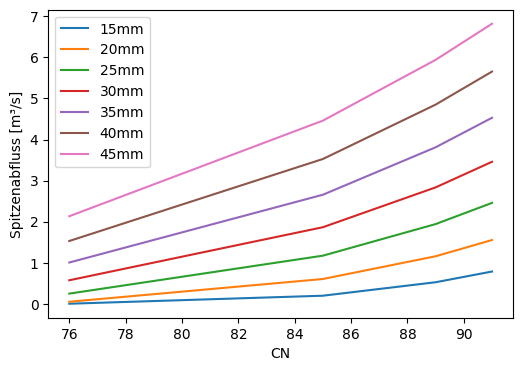

In [21]:
cn_df = pd.DataFrame(CN_Q)
fig, ax = plt.subplots(figsize=(6, 4))
for p in p_bereich:
    ax.plot(CNs, cn_df[p], label=f'{p}mm')

ax.set_xlabel('CN')
ax.set_ylabel('Spitzenabfluss [m³/s]')
ax.legend()

## Flächendetailliertes Modell aus räumlichen Daten

Wie in der Vorlesung besprochen, braucht der Niederschlag Zeit, um zum Auslass eines EZGs zu fließen. Auf dem Fließweg gibt es  komplexe Wechselwirkungen mit der Atmosphäre, der Vegetation, der Bodenoberfläche und dem Untergrund, die es sehr schwierig machen, die Reaktion des Einzugsgebiets auf Niederschläge genau vorherzusagen. Jetzt verwenden wir DEM-Daten, um ein Becken abzugrenzen und ein einfaches flächendetailliertes Modell zu erstellen, um aus stündlichen und täglichen Niederschlagsdaten eine Einheitsganglinie zu erstellen. Wir versuchen im Anschluss die von unserem Modell vorhergesagte Abflussmenge mit einer Zeitreihe gemessener Werte aus dem Fitzsimmons Creek zu vergleichen.

>**Hinweis**: Von hier an verlassen wir das Beispiel des 1 $\text{km}^2$-Einzugsgebietes und betrachten ein größeres EZG der gleichen Region, das jedoch in den Fitzsimmons Creek entwässert. 

### Importieren und visualisieren des DEM

Hier verwenden wir die Bibliothek [Pysheds](https://github.com/mdbartos/pysheds), um das DEM zu verarbeiten.

In [22]:
data_path = '../../Notebook_Daten/Hausarbeit_Daten/'
dem_file = 'Whistler_DEM.tif'
dem_path = data_path + dem_file

grid = Grid.from_raster(dem_path)
dem = grid.read_raster(dem_path)

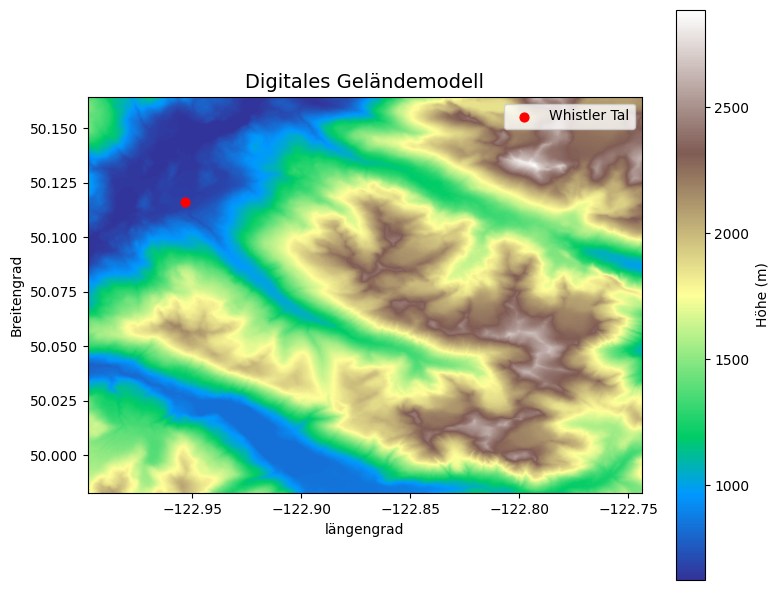

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=2)
plt.colorbar(label='Höhe (m)')

# Zeige den Ort Whistler als Punkt auf dem Einzugsgebiet
plt.scatter(x=[-122.9535], y=[50.1162], zorder=3, c='red', s=40, label='Whistler Tal')

plt.grid(zorder=0)
plt.title('Digitales Geländemodell', size=14)
plt.xlabel('längengrad')
plt.ylabel('Breitengrad')
plt.legend()
plt.tight_layout()

### Identifizierung und Füllung von Senken im DEM

Die bevorzugte Eingabe für den Fließrichtungs-Prozess ist ein digitales Höhenmodell (DEM) ohne Senken. Wenn Senken vorkommen, kann dies zu einem fehlerhaften Fließrichtungs-Raster führen. In einigen Fällen können die Daten identifizierte Senken enthalten. Deswegen ist es i.d.R. wichtig, die Morphologie der Fläche gut genug zu kennen, um zu wissen, welche Features wirklich Senken in der Erdoberfläche sind, und bei welchen Features es sich nur um Fehler in den Daten handelt

In [24]:
# Aufbereitung DEM
# ----------------------
# Senken auffüllen
pit_filled_dem = grid.fill_pits(dem)

# Mulden auffüllen
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Auflösen flacher Bereiche für eine kontinuierliche Abwärtsströmung
inflated_dem = grid.resolve_flats(flooded_dem)

### Fließrichtungen aus DEM ableiten

Jeder Zelle eines DEM-Rasters wird eine Fließrichtung zugewiesen, die durch Bestimmung der Neigung an diesem Pixel/dieser Zelle berechnet wird. Die Steigung wird durch Höhenvergleich mit den 8 umgebenden/verbundenen Pixeln ermittelt. Den Richtungen wird einer von acht Werten zugewiesen, die 8-Bit-Ganzzahlen ($2^1, 2^2, 2^3, \dots 2^7$) entsprechen.

| | | |
|---|---|---|
| 32 | 64 | 128 |
| 16 | - | 1 |
| 8 | 4 | 2 |

In [25]:
# import matplotlib.cm as cmx
# import matplotlib.colors as colors
# # D8-Flussrichtungen aus DEM bestimmen (D8 = Fließmodellalgorithmus)
# # ----------------------
# # Richtungsspezifisches Mapping festlegen
# dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# # Berechne Fließrichtungen
# # -------------------------------------
# fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# fig = plt.figure(figsize=(8,6))
# fig.patch.set_alpha(0)

# # Wir müssen die Farben normalisieren umd Kontrast herzustellen
# cNorm  = colors.PowerNorm(gamma=0.5)
# plt.imshow(fdir, extent=grid.extent, norm=cNorm,
# cmap='terrain', zorder=2)
# boundaries = ([0] + sorted(list(dirmap)))
# plt.colorbar(boundaries= boundaries,
#              values=sorted(dirmap))
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.title('Fließrichtungs Raster', size=14)
# plt.grid(zorder=-1)
# plt.tight_layout()

### Abflussakkumullation ableiten

Da  Jeder Zelle ist eine Richtung zugeordnet ist, ist das Ergebnis der Abflussakkumulation ein Raster zu jeder Zelle, bestimmt durch das Akkumulieren der Gewichtung für alle Zellen, die in einzelne tiefer gelegene Zellen fließen.

In [26]:
# # Berechne Abflussakkumullation
# # --------------------------
# acc = grid.accumulation(fdir, dirmap=dirmap)

# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)
# plt.grid('on', zorder=0)
# im = ax.imshow(acc, extent=grid.extent, zorder=2,
#                cmap='cubehelix',
#                norm=colors.LogNorm(1, acc.max()),
#                interpolation='bilinear')
# plt.colorbar(im, ax=ax, label='höher gelegene Zellen')
# plt.title('Abflussakkumulation', size=14)
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.tight_layout()

### Abgrenzung eines EZGs über Wasserscheiden

Nachfolgend skizzieren wir ein Einzugsgebiet, das dem Pegel am Fitzsimmons Creek entspricht. Water Survey Kanada hat [kürzlich](https://open.canada.ca/data/en/dataset/0c121878-ac23-46f5-95df-eb9960753375) Polygone von Einzugsgebieten für fast 7000 Pegel in ganz Kanada veröffentlicht. Darüber hinaus werden Pegel auch als shape files bereitgestellt. Eine Einschränkung ist leider, dass wir unseren Punkt als Datei (.shp oder .geojson) angeben müssen und nicht nur Koordinaten bereitstellen können. Der Referenzpegel soll hier der Auslauf des Einzugsgebietes sein. Wenn wir hochaufgelöste Daten und unvollständige Koordinaten eines Abflusspunkts haben, erhalten wir nicht das richtige Pixel, das dem Auslass entspricht.

In [27]:
# # Einzugsgebiet abgrenzen
# # ---------------------
# # Abflusspunkt festlegen (WSC Station am Fitzsimmons Creek in Whistler: 08MG026)
# x, y = -122.9488, 50.12025

# # Hinweis: Wenn mithilfe des Schwellenwertes ein Einzugsgebiet definiert wird, 
# # stellen die Abflusspunkte des EZGs die Knoten eines Gewässernetzwerkes dar, 
# # das aus der Abflussakkumulation abgeleitet wird. Deshalb müssen sowohl ein 
# # Abflussakkumulations-Raster als auch die Mindestzahl von Zellen, aus denen ein 
# # Wasserlauf besteht (der Schwellenwert), angegeben werden.

# # einen Schwellenwert für die Abflussakkumulation in Zellen angeben
# # Für dieses Raster entsprechen 500 Zellen etwa 0,5 km².
# accumulation_threshold = 500

# # Abflusspunkt zu hoch akkumulierter Zelle fangen (snappen)
# x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# # Einzugsgebiet abgrenzen
# catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
#                        xytype='coordinate')

# # Zurechtschneiden und Plotten des Einzugsgebiets
# # ---------------------------
# # Bounding Box auf das Einzugsgebiet kürzen (clippen)
# grid.clip_to(catch)
# clipped_catch = grid.view(catch)

In [28]:
# # Einzugsgebiet plotten
# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)

# plt.grid('on', zorder=0)
# im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent, zorder=1, cmap='Greys_r')
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.title('Abgegrenztes Einzugsgebiet', size=14)

In [29]:
# # Flussnetzwerk extrahieren
# # ---------------------
# branches = grid.extract_river_network(fdir, acc > 500, dirmap=dirmap)

# fig, ax = plt.subplots(figsize=(8.5,6.5))

# plt.xlim(grid.bbox[0], grid.bbox[2])
# plt.ylim(grid.bbox[1], grid.bbox[3])
# ax.set_aspect('equal')

# for branch in branches['features']:
#     line = np.asarray(branch['geometry']['coordinates'])
#     plt.plot(line[:, 0], line[:, 1])
    
# _ = plt.title('D8 Abflussnetzwerk', size=14)

### Berechnen der Entfernung zu den flussauffärtigen Zellen

In [30]:
# # Berechnung der Entfernung von jeder Zelle zum Auslass
# # -------------------------------------------
# dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
#                                xytype='coordinate')

# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)
# plt.grid('on', zorder=0)
# im = ax.imshow(dist, extent=grid.extent, zorder=2,
#                cmap='cubehelix_r')
# plt.colorbar(im, ax=ax, label='Distanz zum Auslauf (Zellen)')
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.title('Fließlänge', size=14)

### Berechnen der gewichteten Fließzeit

Basierend auf der Annahme, dass sich Wasser mit derselben Geschwindigkeit fortbewegt (Oberflächenabfluss ist langsamer), bis es sich in einem Gerinne ansammelt und seine Geschwindigkeit startk ansteigt, ordneen wir jeder Zellte eine Fließzeit zu.

In [31]:
# # Berechnung der Abflussakkumulation
# acc = grid.accumulation(fdir)

# # Wir nehmen an, dass Wasser in unseren Gerinnezellen (>= 500 Akkumulation) 
# # 10 mal schneller fließt als in Hangzellen (< 500 Ansammlungen)
# # d.h. wenn die durchschnittliche Fließgeschwindigkeit 1m/s beträgt, beträgt die Hanggeschwindigkeit 0,1m/s = 10 cm/s
# weights = acc.copy()
# weights[acc >= accumulation_threshold] = 0.1
# weights[(acc > 0) & (acc < accumulation_threshold)] = 1

# # Berechne gewichtete Entfernung zum Auslass
# weighted_dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, weights=weights, xytype='coordinate')

In [32]:
# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)
# # plt.grid('on', zorder=0)
# im = ax.imshow(weighted_dist, zorder=2,
#                cmap='cubehelix_r')
# plt.colorbar(im, ax=ax, label='Distanz zum Auslass (Zellen)')
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.title('Gewichtete Distanz zu Auslass', size=14)

### Entwickeln Sie ein einfaches Niederschlags-Abfluss-Modells

Da wir nun die gewichteten Fließentfernungen für jede Zelle im abgegrenzten Einzugsgebiet haben, können wir den Niederschlag auf jede „Zelle“ anwenden, um eine Abflussganglinie zu rekonstruieren.

Zuerst benötigen wir die Zellenabmessungen (die Größe jedes Rasterpixels auf dem Boden). Aus den [USGS Hydrosheds-Informationen](https://hydrosheds.cr.usgs.gov/datadownload.php) wissen wir, dass die Auflösung 15 (Grad) Sekunden beträgt. Da die Erde keine perfekte Kugel ist, werden [Koordinatenprojektionssysteme](https://epsg.io/) (CRS) verwendet, um die Erdoberfläche genähert abzubilden, sodass räumliche Entfernungen genauer dargestellt werden können.

Beachtet, dass unsere „gewichtete Distanz“ nur einen relativen Unterschied zwischen den "Abflussakkumulationszellen" und den "Nichtflussakkumulationszellen" liefert. Wir müssen diese Werte noch in eine zeitabhängige Form umwandeln.

Vorerst gehen wir davon aus, dass die durchschnittliche Fließgeschwindigkeit für die Abflussakkumulationszellen 1 m/s und für die Hangzellen 0,01 m/s beträgt. So können wir die ungewichtete und gewichtete Konzentrationszeit (Zeit von der entferntesten Zelle bis zum Auslass).

Das DEM stammt aus dem USGS 3DEP-Programm und hat eine Auflösung von etwa 30 m (jedes Pixel stellt eine quadratische Fläche von etwa 30 x 30 m dar). Wir haben das (Entfernungs-)Gewicht der Gerinnezellen reduziert, sodass die Entfernung proportional zu unserer Schätzung der Hanggeschwindigkeit ist und wir die Entfernung in Zeit umwandeln können, indem wir die gewichtete Entfernung durch 1 m/s dividieren.

In [33]:
# # festlegen der Rasterpixelauflösung (m x m)
# resolution = (30, 30)

# # Die Zellen können nach ihrem gewichteten Abstand zum Auslass gruppiert werden, um den 
# # den Prozess der Berechnung des Beitrags jeder Zelle zum finalen Abfluss am Auslass zu vereinfachen
# dist_df = pd.DataFrame()
# dist_df['weighted_dist'] = weighted_dist.flatten()
# print(f'Dataframe vor der Aufbereitung {dist_df}')

# # entferne Zellen, welche nicht zum Einzugsgebiet gehören
# # und runde die Abflusszeit auf die nächste Entfernugs Einheit (Anzahl an Zellen)
# dist_df = dist_df[np.isfinite(dist_df['weighted_dist'])].round(0)
# print(f'Dataframe nach der Aufbereitung: {dist_df}')

In [34]:
# # Ermitteln der Anzahl der Zellen für jeden Abstand
# grouped_dists = pd.DataFrame(dist_df.groupby('weighted_dist').size())
# grouped_dists.columns = ['num_cells']

In [35]:
# # Verteilungen der gewichteten Abstände darstellen
# W = np.bincount(weighted_dist[np.isfinite(weighted_dist)].astype(int))
# fig, ax = plt.subplots(figsize=(10, 5))
# plt.fill_between(np.arange(len(W)), W, 0, edgecolor='seagreen', linewidth=1, facecolor='lightgreen', alpha=0.8)
# plt.ylabel(r'Anzahl d. Zellen bei Entfernung $x$ vom Auslass', size=14)
# plt.xlabel(r'Entfernung vom Auslass (x) [Zellen]', size=14)
# plt.title('Weite Funktion W(x)', size=16)

In [36]:
# flow_velocity = 0.1 # m/s

# w_time = weighted_dist * resolution[0] / flow_velocity / 3600
# W_time = np.bincount(w_time[np.isfinite(w_time)].astype(int))
# fig, ax = plt.subplots(figsize=(10, 5))
# plt.fill_between(np.arange(len(W_time)), W_time, 0, edgecolor='seagreen', linewidth=1, facecolor='lightgreen', alpha=0.8)
# plt.ylabel(r'Anzahl der Zellen $x$ Stunden vom Auslass', size=14)
# plt.xlabel(r'Zeit zum Auslass $x$ (Stunden)', size=14)
# plt.title('Weite Funktion W(x) ~ Einheitsganglinie', size=16)

>**Hinweis**: Oben haben wir eine geschätzte Einheitsganglinie für eine Niederschlagseinheit entwickelt, die gleichmäßig über das Einzugsgebiet fällt. Dies haben wir allein mit Höhendaten (DEM) und einer Annahme zum Unterschied in den Fließgeschwindigkeiten zwischen Gerinnen und Hangströmung gemacht.

### Berechnung des Gesamtabflusses und Vergleich ihn mit dem gemessenen Tagesvolumen für die zweitägige Aufzeichnung

>**HINWEIS**: Wenn Ihr den Abflusskoeffizienten unten aktualisiert, müsst ihr **den Code von hier aus erneut ausführen**, um den DataFrame „runoff_df“ neu zu initialisieren. Andernfalls werden die Werte akkumuliert.

In [37]:
# Erstellung einer Einheitsganglinie für jeden Zeitschritt
runoff_df = pd.DataFrame(np.zeros(len(hourly_df)))
runoff_df.columns = ['Total Precip (mm)']
runoff_df.index = hourly_df.index.copy()
end_date = pd.to_datetime(runoff_df.index.values[-1]) + pd.DateOffset(hours=1)
max_distance = max(grouped_dists.index)

NameError: name 'grouped_dists' is not defined

In [85]:
def calculate_flow_time(distance, v):
    # die Länge des Fließwegs (in Zellen) umrechnen
    # in eine Fließzeit
    return np.ceil(distance * resolution[0] / v / 3600)


In [86]:
# Konzentrationszeit
max_flow_time = calculate_flow_time(max_distance, flow_velocity)
print(f'Der maximale Abflussweg ist {max_distance} Zellen, was einer maximalen Fließzeit von {max_flow_time} Stunden entspricht.')

extended_df = pd.DataFrame()
extended_df['Total Precip (mm)'] = [0 for e in range(int(max_flow_time) + 1)]
extended_df.index = pd.date_range(end_date, periods=max_flow_time + 1, freq='1H')

# Anhängen der Extra Zeit and den Abfluss dataframe
runoff_df = pd.concat([runoff_df, extended_df])
runoff_df['Runoff (cms)'] = 0

Der maximale Abflussweg ist 102.0 Zellen, was einer maximalen Fließzeit von 9.0 Stunden entspricht.


Die Zelle unten ist eine umfangreiche Berechnung und kann einige Zeit dauern. Was unten passiert, ist, dass wir für jede Niederschlagsstunde den Zeitversatz berechnen, den der Fluss benötigt, um von jeder Zelle zum Auslass zu gelangen. Da nicht jede Zelle die gleiche Zeit benötigt, um zum Auslass zu gelangen, addieren wir den Abfluss jeder Zelle zu einem zukünftigen Zeitpunkt, der der Fließzeit der Zelle entspricht. Wir machen es etwas effizienter, indem wir Zellen mit gleichem Abstand gruppieren.

Nachfolgend nehmen wir einen Abflusskoeffizienten von 0,3 an. D. h. 30 % unseres Niederschlags werden Abflusswirksam sein. Später werden wir sehen, wie gut Modellergebnisse mit den gemessenen Werten zusammenpassen, und versuchen, diesen Koeffizienten zu validieren.

In [87]:
runoff_coefficient = 0.3

for ind, row in hourly_df.iterrows():
    this_hyd = hourly_df[['precipitation']].copy()
    hydrograph = pd.DataFrame()
    for weight_dist, num_cells in grouped_dists.iterrows():
        weighted_time = calculate_flow_time(weight_dist, flow_velocity)
        outlet_time = ind + pd.Timedelta(hours=weighted_time)
        # Rundung der Fließzeit auf die nächste Stunde 
        # Angleichung an die stündlichen Abflussdaten
        if weighted_time < 1:
            outlet_time = ind + pd.Timedelta(hours=1)
            
        precip_vol = num_cells.values[0] * row['precipitation']
        runoff_vol = precip_vol * runoff_coefficient / 1000 * resolution[0]**2 
        runoff_rate = runoff_vol  / 3600  # Umrechnung von m³/h in m³/s    
        runoff_df.loc[outlet_time, 'Runoff (cms)'] += runoff_rate


In [88]:
runoff_df['day'] = runoff_df.index.day
# Umrechnung von m³/s in m³/h (cmh)
runoff_df['runoff_vol_cmh'] = runoff_df['Runoff (cms)'] * 3600

cumulative_vol = runoff_df[['runoff_vol_cmh', 'day']].groupby('day').sum()
cumulative_vol

runoff_vol_cmh
day                
28       102690.396
29       293762.808

In [89]:
# Abflusszeitreihe importieren
whis_flow_df = pd.read_csv(os.path.join(data_path, '08MG026_daily.csv'),
header=1, parse_dates=['Date'], index_col=['Date'])
# whis_flow_df = whis_flow_df[whis_flow_df['2005-09-27': '2005-09-31']]
# whis_flow_df
whis_flow_df = whis_flow_df['2005-09-27':'2005-09-30'].round(1)
whis_flow_df

ID  PARAM  Value  SYM
Date                                  
2005-09-27  08MG026      1    1.3  NaN
2005-09-28  08MG026      1    1.5  NaN
2005-09-29  08MG026      1    4.8  NaN
2005-09-30  08MG026      1    2.8  NaN

In [90]:
cumulative_vol.values.flatten()
whis_flow_df.loc['2005-09-28':'2005-09-29']

ID  PARAM  Value  SYM
Date                                  
2005-09-28  08MG026      1    1.5  NaN
2005-09-29  08MG026      1    4.8  NaN

In [91]:
# für den Abfluss in Whistler kann der Basisabfluss subtrahiert werden
# nehmt an, dieser ist 1.3 cms für 27st September
whis_flow_df['excess_flow'] = whis_flow_df['Value'] - 1.3
# Umrechnung des durchschnittlichen täglichen Durchflusses in das tägliche Volumen in m³/Tag
whis_flow_df['excess_volume'] = whis_flow_df['excess_flow'] * 3600 * 24
whis_flow_df.loc['2005-09-28':'2005-09-29', 'model_volume'] = cumulative_vol.values.flatten()

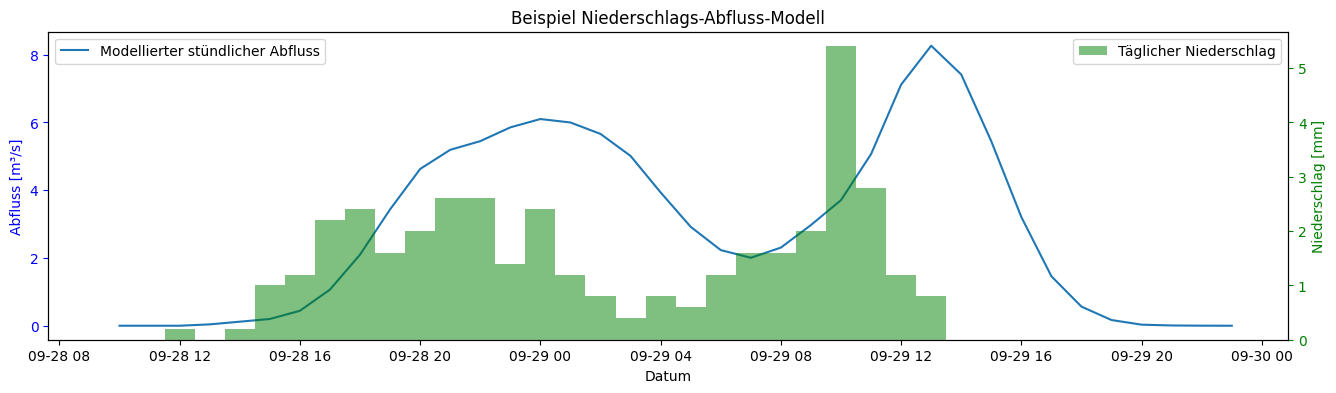

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(runoff_df.index, runoff_df['Runoff (cms)'], label="Modellierter stündlicher Abfluss")
# ax.plot(whis_flow_df.index, whis_flow_df['Value'], label='Gemessener täglicher Durchschnittsabfluss [m³/s]')

ax.set_xlabel('Datum')
ax.set_ylabel('Abfluss [m³/s]', color='blue')
ax.set_title('Beispiel Niederschlags-Abfluss-Modell')
ax.legend(loc='upper left')
ax.tick_params(axis='y', colors='blue')

ax1 = ax.twinx()
# darstellen der Niederschlagsdaten
ax1.bar(hourly_df.index, width=pd.Timedelta(hours=1),
 height=hourly_df['precipitation'], color='green', alpha=0.5,
         label="Täglicher Niederschlag")
ax1.set_ylabel('Niederschlag [mm]', color='green')
ax1.tick_params(axis='y', colors='green')
ax1.legend(loc='upper right')

### Vergleich des modellierten vs. gemessenen Abfluss

Wir können den stündlich modellierten und den täglich gemessenen Durchfluss nicht direkt vergleichen, aber wir können das Gesamtvolumen vergleichen. 

Wir vergleichen also den modellierten Überschussabfluss aus Niederschlägen mit dem gemessenen Abfluss (bereinigt um den Basisabfluss). Nachfolgend subtrahieren wir den Basisabfluss (der als erster Tag des gemessenen Abflusses angenommen wird) von der Zeitreihe des täglichen Abflusses, addieren den gesamten Volumenfluss über das zweitägige Niederschlagsereignis und vergleichen ihn mit dem gesamten modellierten Abflussvolumen (der bereits vorhanden ist) des selben Zeitraumes.

In [93]:
tot_runoff = whis_flow_df[['excess_volume', 'model_volume']].sum()
relative_error = 100*( tot_runoff['excess_volume'] - tot_runoff['model_volume']) / tot_runoff['excess_volume']

print(f'Bei einem Abflusskoeffizienten von {runoff_coefficient} ({100*runoff_coefficient}% des Niederschlages sind effektiver Niederschlag, der Vorhersageerror über das zweitägige Niederschlagsereignise ist {relative_error:.0f}%) ')

Bei einem Abflusskoeffizienten von 0.3 (30.0% des Niederschlages sind effektiver Niederschlag, der Vorhersageerror über das zweitägige Niederschlagsereignise ist 12%) 


Ähnlich bei bei dem Zeitbeiwertverfahren schauen wir uns die Unsicherheit an, welche durch die Wahl des Abflusskoeffizienten begründet ist. Die SCS-Verfahren drücken Niederschlag, der nicht effektiv ist (also nicht als Direktabfluss wirksam wird), als **Verlust** aus.

In diesem Beispiel testen wir den Niederschlagsverlust durch Infiltration, der den effektiven Niederschlag, die Verzögerungszeit und die Konzentrationszeit bestimmt. Um die Annahmen besser zu veranschaulichen, visualisieren wir den Niederschlag in einer Bereich von (konstanten) Verlustraten im Vergleich zu den stündlichen Daten, die wir oben importiert haben.

In [94]:
precip_losses = [1, 2, 4] # mm/hr

p = figure(title=f'Niederschlag vs. Verluste', width=750, height=300, x_axis_type='datetime')

p.vbar(x='time', width=pd.Timedelta(hours=1), top='precipitation', 
bottom=0, source=hourly_source, legend_label='Stündlicher Niederschlag', 
color='royalblue', fill_alpha=0.5)

t_loss = [hourly_df.index[0], hourly_df.index[-1]]

colors = ['blue', 'green', 'orange', 'red']
i = 0
for l in precip_losses:
    p.line(
        t_loss, [l, l], 
        line_dash='dashed', legend_label=f'{l}mm/h Verlust',
        color=colors[i]
    )
    i += 1

p.legend.location = 'top_left'
p.xaxis.axis_label = 'Datum'
p.yaxis.axis_label = 'Niederschlag [mm]'
p.toolbar_location='above'
show(p)

Das obige Diagramm zeigt den effektiven Niederschlag als blauen Bereich über jeder der Verlustfunktionslinien. Wir können die verschiedenen Mengen des effektiven Niederschlags jedoch auch grafisch darstellen.

In [95]:
for l in precip_losses:
    hourly_df[f'excess_{l}'] = (hourly_df['precipitation'] - l).clip(0, None)


hourly_df['day'] = hourly_df.index.day

excess_rainfall = hourly_df[[f'excess_{l}' for l in precip_losses] + ['day']].groupby('day').sum()
excess_rainfall

excess_1  excess_2  excess_4
day                              
28        8.0       1.8       0.0
29       10.4       4.6       1.4

In [96]:
hourly_source = ColumnDataSource(hourly_df)
p = figure(title=f'Effektiver Niederschlag', width=650, height=250, x_axis_type='datetime')

i = 0
for l in precip_losses:
    p.vbar(x='time', width=pd.Timedelta(minutes=20), top=f'excess_{l}', 
    bottom=0, source=hourly_source, legend_label=f'{l}mm Verlust', 
    color=colors[i], fill_alpha=0.5)
    # Verschiebung des Index um 20min, damit die Balken nebeneinander liegen
    hourly_df.index += pd.Timedelta(minutes=20)
    hourly_source = ColumnDataSource(hourly_df)
    i += 1

# in jedem Fall den Index zurücksetzen
hourly_df.index -= pd.Timedelta(hours=1)
p.legend.location = 'top_left'
show(p)

Lasst uns abschließend den Bereich der Niederschlagsverlustwerte anhand der Gesamtniederschlagsmengen sowie der gemessenen Gesamtabflussmenge vergleichen um zu sehen, wie diese mit unserem angenommenen Abflusskoeffizienten von 30 % übereinstimmen.

In [97]:
total_hourly_vol = hourly_df.groupby('day').sum()[['precipitation', 'excess_1', 'excess_2', 'excess_4']]
tot_df = total_hourly_vol.sum()

for ev in [1, 2, 4]:
    e_pct = tot_df[f'excess_{ev}'] / tot_df['precipitation']
    tot_df[f'pct_excess_{ev}'] = e_pct
    print(f'{ev}mm Abflussverlust führt zu {100*e_pct:.0f}% des Niederschlags, der als Direktabfluss wirksam wird')

1mm Abflussverlust führt zu 46% des Niederschlags, der als Direktabfluss wirksam wird
2mm Abflussverlust führt zu 16% des Niederschlags, der als Direktabfluss wirksam wird
4mm Abflussverlust führt zu 3% des Niederschlags, der als Direktabfluss wirksam wird


## Fragen, die im Rahmen der Hausarbeit beantwortet werden sollen:

1. Welche Faktoren in unserem Einheitsganglinienmodell wirken sich auf die Größe des Scheitelabflusses aus?
2. Wie lassen sich die Schätzungen des SCS-CN Scheitelabflusses mit der Gerinnekapazität vergleichen, die wir zu Beginn ermittelt haben? Würdet ihr das Risiko eingehen, dass das Gerinne überläuft, möglicherweise das aquatische Ökosystem in Fitzsimmons Creek gefährdet und ihr somit das Fischereigesetz verletzen würdet?
3. Gegen Ende des Notebooks (bei unserem flächendetaillierten Modell) schätzten wir die Abflussreaktion anhand der täglichen Niederschläge und gehen von einem Abflusskoeffizienten von 0,3 aus. Wie könnten ihr verifizieren, dass dies eine korrekte Annahme ist? Was passiert mit dem restlichen Niederschlag?
4. Würdet ihr eines der in diesem Notebook besprochenen Modelle als „besser“ oder „schlechter“ bewerten? Könnt ihr die Modelle in einer kurzen Erläuterungen zu folgenden Punkten verteidigen: 
i) Informationsanforderungen, 
ii) Komplexität & iii) Interpretierbarkeit

### Bonus

5. Wir haben die Python-Bibliothek pysheds verwendet, um ein Einzugsgebiet an einem bestimmten Ort am FitzSimmons Creek in Whistler abzugrenzen. Lässt sich aus der Rasterdatei des Einzugsgebietes auch die Einzugsgebietsfläche ermitteln? Geht hier von einer Zellenauflösung von 30 x 30 m aus.

### Mega-Bonus

6. Der Anteil des effektiven Niederschlags, hängt von vielen Bedingungen ab. Im Notebook 1-Datenordner findet ihr Langzeitaufzeichnungen des täglichen Niederschlags und des täglichen Abflusses. Der Abfluss bezieht sich hier auf ein Gebiet von 90.34 km². Lassen sich anhand beider Aufzeichnungen ein "langfristiger" (robusterer) Abflusskoeffizienten schätzen? Wie unterscheidet sich dieser möglicherweise über das Jahr?